In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
file = '/content/LJ001-0001.wav'
signal, sample_rate = librosa.load(file, sr=None)

**Computing real cepstrum by log magnitude of inverse fourier transform by applying hamming window**

In [10]:
frame_length = int(0.03 * sample_rate)
frame_start = len(signal) // 2
frame = signal[frame_start:frame_start + frame_length]
windowed_frame = frame * np.hamming(len(frame))
spectrum = np.fft.fft(windowed_frame)
log_magnitude = np.log(np.abs(spectrum) + 1e-10)
real_cepstrum = np.fft.ifft(log_magnitude).real

**Plotting the cepstrum of the selected frame**

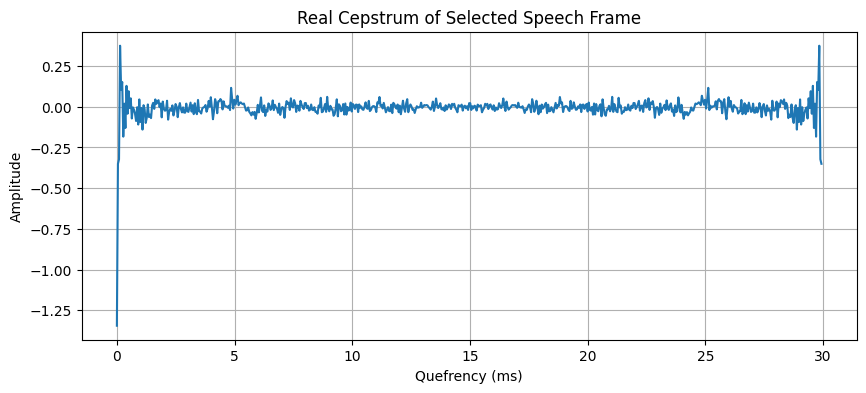

In [11]:
plt.figure(figsize=(10, 4))
quefrency = np.arange(len(real_cepstrum))/sample_rate
plt.plot(quefrency * 1000, real_cepstrum)
plt.title("Real Cepstrum of Selected Speech Frame")
plt.xlabel("Quefrency (ms)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

**Determining voiced speech frames by computing the real cepstrum in the 5 to 20 ms range and finding the peak, pitch period and fundamental frequency**

In [12]:
def is_voiced_by_cepstrum(frame, sample_rate, peak_threshold=0.05):
    windowed = frame * np.hamming(len(frame))
    spectrum = np.fft.fft(windowed)
    log_mag = np.log(np.abs(spectrum) + 1e-10)
    cepstrum = np.fft.ifft(log_mag).real
    min_quef = int(0.005 * sample_rate)
    max_quef = int(0.02 * sample_rate)
    peak = np.max(cepstrum[min_quef:max_quef])
    return peak > peak_threshold

In [13]:
if is_voiced_by_cepstrum(windowed_frame, sample_rate):
    print("Voiced frame detected")
    min_quef = int(0.005 * sample_rate)
    max_quef = int(0.02 * sample_rate)
    peak_index = np.argmax(real_cepstrum[min_quef:max_quef]) + min_quef
    pitch_period_sec = peak_index/sample_rate
    F0 = 1/pitch_period_sec
    print("Pitch period:", pitch_period_sec*1000, "seconds")
    print("Estimated fundamental frequency:", F0, "Hz")
else:
    print("Unvoiced frame, because there is no clear cepstral peak")

Voiced frame detected
Pitch period: 5.124716553287982 seconds
Estimated fundamental frequency: 195.13274336283186 Hz


**Low pass liftering to remove the glottal excitation with a 10 ms cutoff and visualisation with original log magnitude spectrum**

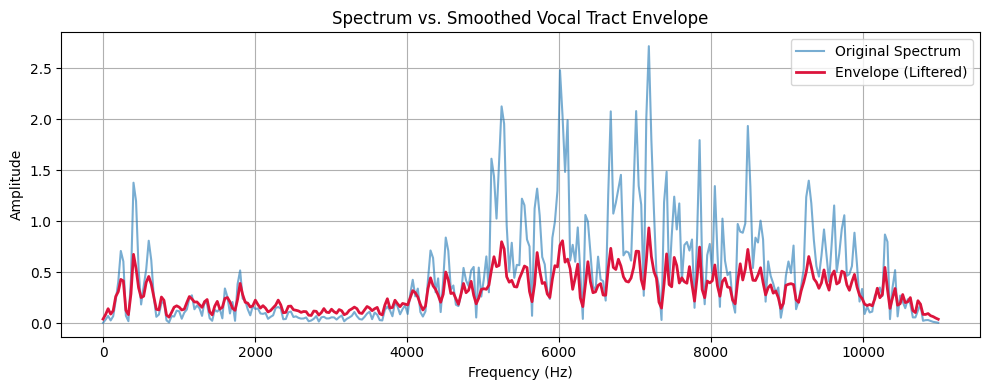

In [9]:
lifter_cutoff = int(0.01 * sample_rate)
cepstrum_lp = np.copy(real_cepstrum)
cepstrum_lp[lifter_cutoff:] = 0
smoothed_log_mag = np.fft.fft(cepstrum_lp).real
envelope = np.exp(smoothed_log_mag)
original_log_mag = np.log(np.abs(spectrum) + 1e-10)
frequencies = np.linspace(0, sample_rate, len(envelope))

plt.figure(figsize=(10, 4))
plt.plot(frequencies[:len(envelope)//2], np.exp(original_log_mag[:len(envelope)//2]), label='Original Spectrum', alpha=0.6)
plt.plot(frequencies[:len(envelope)//2], envelope[:len(envelope)//2], label='Envelope (Liftered)', linewidth=2, color='crimson')
plt.title("Spectrum vs. Smoothed Vocal Tract Envelope")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()